**Table of contents**<a id='toc0_'></a>    
- [Programming Question](#toc1_)    
  - [Base model performance](#toc1_1_)    
  - [HyperParameter Exploration](#toc1_2_)    
    - [Exploring different hidden layer sizes and activation functions](#toc1_2_1_)    
    - [Exploring Solver](#toc1_2_2_)    
    - [Exploring learning_rate_init](#toc1_2_3_)    
    - [Exploring tol](#toc1_2_4_)    
    - [Adam-specific hyperparameters](#toc1_2_5_)    
  - [Evaluating the Chosen Model's Performance](#toc1_3_)    
  - [Hypothesis testing](#toc1_4_)    
    - [Load the model from task 2 and get predictions](#toc1_4_1_)    
    - [Get task 3 model accuracy](#toc1_4_2_)    
    - [Conduct Hypothesis testing](#toc1_4_3_)    
      - [Conclusion of test](#toc1_4_3_1_)    
  - [Conclusion](#toc1_5_)    
- [Markdown Question](#toc2_)    
  - [Answer](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Programming Question](#toc0_)

_Repeat Task 3.2 after rescaling all features in the range [10; 15]. Use
hypothesis testing to compare the performance of the models developed
in this task with that developed in Tasks 3.2_

In [175]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import warnings

from scipy.stats import ttest_rel
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, auc, roc_curve
from sklearn.model_selection import ParameterGrid
from sklearn.calibration import label_binarize

In [2]:
# Suppress convergence warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def load_dataset()-> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Uses np.load to load the training and test datasets used for the models in these notebooks.

    Returns:
        tuple: A tuple containing four numpy arrays representing the training and test datasets.
               The tuple elements are as follows:
               - features_train: A numpy array containing the features of the training dataset.
               - targets_train: A numpy array containing the target labels of the training dataset.
               - features_test: A numpy array containing the features of the test dataset.
               - targets_test: A numpy array containing the target labels of the test dataset.
    """    
    # Train dataset
    features_train = np.load("x_train.npy")
    targets_train = np.load("y_train.npy")
    # Test dataset
    features_test = np.load("x_test.npy")
    targets_test = np.load("y_test.npy")
    return features_train, targets_train, features_test, targets_test

In [4]:
features_train, targets_train, features_test, targets_test = load_dataset()
np.shape(features_train), np.shape(features_test)

((16200, 512), (5400, 512))

In [5]:
preprocess_pipeline = Pipeline(steps = [
    ('scaler', MinMaxScaler(feature_range=(10, 15))) 
    ])  

In [6]:
features_train = preprocess_pipeline.fit_transform(features_train, targets_train)
features_train

array([[10.9368847 , 10.        , 10.        , ..., 10.68048973,
        10.046565  , 10.        ],
       [10.        , 10.        , 10.        , ..., 11.86980557,
        10.13784339, 10.08440438],
       [10.31051824, 10.05505482, 10.01650893, ..., 10.        ,
        10.14558522, 10.        ],
       ...,
       [10.        , 10.63750927, 10.04704205, ..., 10.50585373,
        10.19722618, 10.        ],
       [10.        , 10.        , 10.09313057, ..., 10.        ,
        10.06820198, 10.001876  ],
       [10.1689061 , 10.        , 10.        , ..., 10.0206765 ,
        10.23170489, 10.        ]])

In [7]:
features_test = preprocess_pipeline.transform(features_test)
features_test

array([[10.04300707, 10.        , 10.04223532, ..., 12.12035257,
        10.24317351, 10.        ],
       [10.        , 10.        , 10.31878817, ..., 10.1557735 ,
        10.1720742 , 11.6822025 ],
       [10.58846245, 11.24346835, 10.        , ..., 10.58653208,
        10.        , 10.        ],
       ...,
       [10.        , 10.0109834 , 10.02603082, ..., 10.        ,
        10.23908847, 10.        ],
       [14.04788623, 10.        , 10.0787983 , ..., 10.63725183,
        10.19151082, 10.        ],
       [10.51327931, 10.13208005, 10.        , ..., 10.30959205,
        10.21557438, 10.        ]])

## <a id='toc1_1_'></a>[Base model performance](#toc0_)

So all results are reproducible, the random_state hyperparameter will be set to 30 for all models. This particular value was chosen randomly and has no meaning. 

In [8]:
mlp = MLPClassifier(random_state=30)
scores = cross_val_score(mlp, features_train, targets_train, cv=10)
scores.mean()

0.8750617283950618

In [9]:
mlp.fit(features_train, targets_train)
predict = mlp.predict(features_test)

In [10]:
print(classification_report(targets_test, predict))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       613
         1.0       0.96      0.96      0.96       605
         2.0       0.86      0.94      0.90       628
         3.0       0.88      0.71      0.78       499
         4.0       0.94      0.92      0.93       507
         5.0       0.93      0.86      0.89       409
         6.0       0.80      0.80      0.80       481
         7.0       0.94      0.97      0.95       583
         8.0       0.82      0.93      0.87       511
         9.0       0.99      0.95      0.97       564

    accuracy                           0.90      5400
   macro avg       0.90      0.90      0.90      5400
weighted avg       0.90      0.90      0.90      5400



## <a id='toc1_2_'></a>[HyperParameter Exploration](#toc0_)

For each exploration step, the hyperparameter combinations will be compared based on their cross-validation scores.

When exploring of hyperparameters is complete, the expectation is to create a model that has a higher cross-validation score than the base model shown above.

All definitions of hyperparameters explored as well as any other relevant information can be found in task 2.

In [11]:
def mlp_model_cv_score(params: list[dict]) -> list[dict]:
    """Evaluate Multi-Layer Perceptron models with different parameters using cross-validation.

    Args:
        params (list[dict]): A list of dictionaries, each dictionary contains parameters for the MLP model.

    Returns:
        list[dict]: A list of dictionaries, each dictionary contains the parameters and the average cross-validation score for the corresponding model.
    """
    for i in params:
            mlp = MLPClassifier(**i)
            scores = cross_val_score(mlp, features_train, targets_train, cv=10)
            i['score'] = scores.mean()
    return params

In [82]:
def display_scores_line(results: list[dict[str, any]], x_axis: str = 'hidden_layer_sizes', compare: str = 'activation') -> None:
    """Display line plots comparing different settings by cross-validation score.

    Args:
        results (list[dict[str, any]]): A list of dictionaries containing the results data.
        x_axis (str, optional): The variable to be displayed on the x-axis. Defaults to 'hidden_layer_sizes'.
        compare (str, optional): The variable to be compared. Defaults to 'activation'.

    Returns:
        None
    """
    # Extracting data
    comparison_entries = sorted(set(item[f'{compare}'] for item in results))
    x_values = sorted(set(item[f'{x_axis}'] for item in results))  

    scores = {entry: [] for entry in comparison_entries}
    
    for entry in comparison_entries:
        entry_scores = []
        for x_val in x_values:
            matched_items = [item['score'] for item in results if item[f'{compare}'] == entry and item[f'{x_axis}'] == x_val]
            entry_scores.append(matched_items[0] if matched_items else None)  
        scores[entry] = entry_scores

    # Plotting
    plt.figure(figsize=(10, 6))

    for entry in comparison_entries:
        plt.plot(range(len(x_values)), scores[entry], marker='o', label=entry)

    # Set the tick labels 
    plt.xticks(range(len(x_values)), [str(size) for size in x_values], ha='right')

    plt.xlabel(f'{x_axis}')
    plt.ylabel('Scores')
    plt.title(f'Comparing {compare.capitalize()} and {x_axis.capitalize()} Settings by CV Score')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### <a id='toc1_2_1_'></a>[Exploring different hidden layer sizes and activation functions](#toc0_)

In [44]:
params=  {'hidden_layer_sizes': [(10,), (25,), (50,), (75,), (100,)], 
                      'activation': ['identity', 'logistic', 'tanh', 'relu'],
                      'random_state': [30]}
params = list(ParameterGrid(params)) 
params

[{'activation': 'identity', 'hidden_layer_sizes': (10,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (25,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (50,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'identity', 'hidden_layer_sizes': (100,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (25,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (100,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (25,), 'random_state': 30},
 {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'random_state': 3

In [45]:
one_layer_results = mlp_model_cv_score(params)
one_layer_results

[{'activation': 'identity',
  'hidden_layer_sizes': (10,),
  'random_state': 30,
  'score': 0.8719135802469136},
 {'activation': 'identity',
  'hidden_layer_sizes': (25,),
  'random_state': 30,
  'score': 0.8810493827160494},
 {'activation': 'identity',
  'hidden_layer_sizes': (50,),
  'random_state': 30,
  'score': 0.8777777777777777},
 {'activation': 'identity',
  'hidden_layer_sizes': (75,),
  'random_state': 30,
  'score': 0.8542592592592593},
 {'activation': 'identity',
  'hidden_layer_sizes': (100,),
  'random_state': 30,
  'score': 0.8496296296296297},
 {'activation': 'logistic',
  'hidden_layer_sizes': (10,),
  'random_state': 30,
  'score': 0.22537037037037036},
 {'activation': 'logistic',
  'hidden_layer_sizes': (25,),
  'random_state': 30,
  'score': 0.2846296296296296},
 {'activation': 'logistic',
  'hidden_layer_sizes': (50,),
  'random_state': 30,
  'score': 0.23246913580246917},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75,),
  'random_state': 30,
  'score': 0

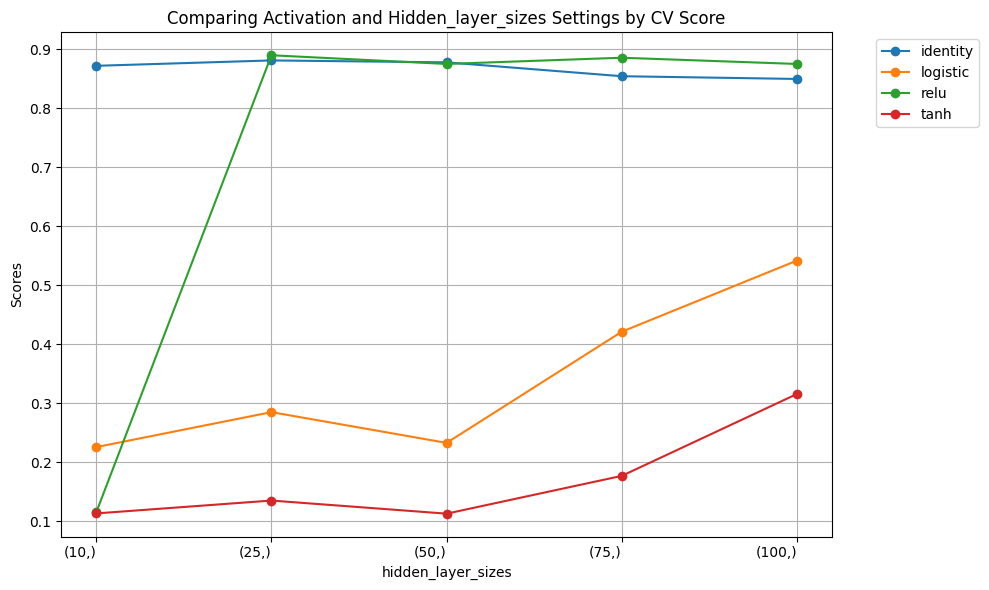

In [83]:
display_scores_line(one_layer_results)

Based on these results, 25, 50, and 100 are the best performing layer sizes. For fine-tuning, more values in the range of 25-50, as well as layers sizes past 100 will be explored. As the logistic and tanh activation functions clearly perform worse than other functions, it will no longer be used in further exploration.

In [14]:
params=  {
    'hidden_layer_sizes': [(15,), (25,), (35,), (45,), (50,),(55,), (65,), (75,), (85,),], 
    'activation': ['logistic','relu'],
    'random_state': [30]}
params = list(ParameterGrid(params)) 
params

[{'activation': 'logistic', 'hidden_layer_sizes': (15,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (45,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (55,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (65,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'logistic', 'hidden_layer_sizes': (85,), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (15,), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (45,), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (55,), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (65,), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (75,), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (85,), 'random_state': 30}]

In [28]:
finer_one_layer_results = mlp_model_cv_score(params)
finer_one_layer_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (15,),
  'random_state': 30,
  'score': 0.1564814814814815},
 {'activation': 'logistic',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'score': 0.39209876543209876},
 {'activation': 'logistic',
  'hidden_layer_sizes': (55,),
  'random_state': 30,
  'score': 0.3979012345679013},
 {'activation': 'logistic',
  'hidden_layer_sizes': (65,),
  'random_state': 30,
  'score': 0.30327160493827165},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75,),
  'random_state': 30,
  'score': 0.42098765432098767},
 {'activation': 'logistic',
  'hidden_layer_sizes': (85,),
  'random_state': 30,
  'score': 0.5721604938271605},
 {'activation': 'relu',
  'hidden_layer_sizes': (15,),
  'random_state': 30,
  'score': 0.14932098765432097},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'score': 0.890925925925926},
 {'activation': 'relu',
  'hidden_layer_sizes': (55,),
  'random_state': 30,
  'score': 0.87703703703

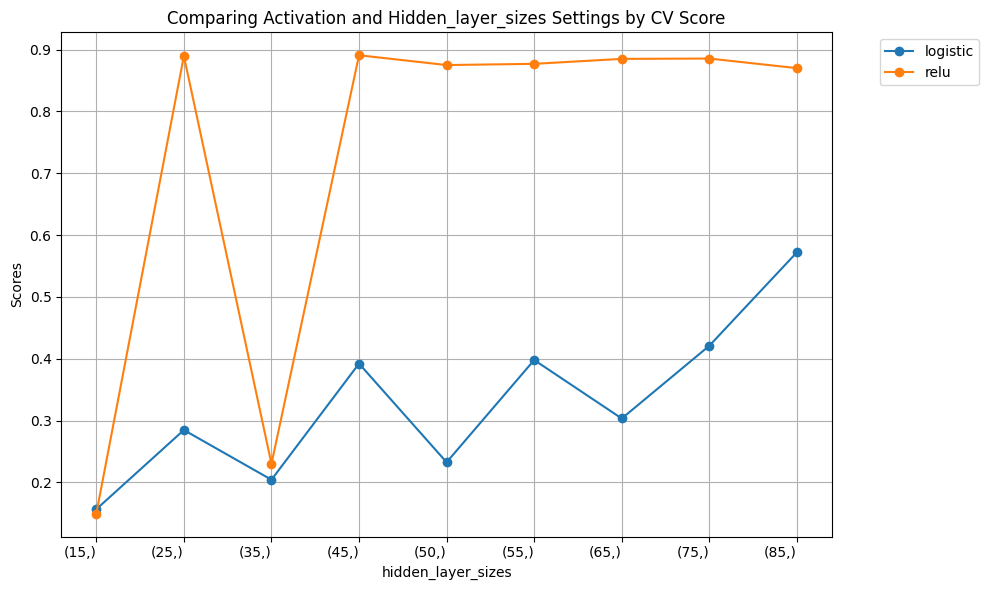

In [84]:
display_scores_line(finer_one_layer_results)

In [33]:
params=  {
    'hidden_layer_sizes': [(10,10), (25,25), (50,50), (75,75), (100,100)], 
    'activation': ['logistic', 'relu'],
    'random_state': [30]
    }
params = list(ParameterGrid(params)) 
params

[{'activation': 'logistic',
  'hidden_layer_sizes': (10, 10),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (25, 25),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (50, 50),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75, 75),
  'random_state': 30},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100, 100),
  'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (25, 25), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (75, 75), 'random_state': 30},
 {'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'random_state': 30}]

In [32]:
two_layers_results = mlp_model_cv_score(params)
two_layers_results

[{'activation': 'logistic',
  'hidden_layer_sizes': (10, 10),
  'random_state': 30,
  'score': 0.2877777777777778},
 {'activation': 'logistic',
  'hidden_layer_sizes': (25, 25),
  'random_state': 30,
  'score': 0.20339506172839505},
 {'activation': 'logistic',
  'hidden_layer_sizes': (50, 50),
  'random_state': 30,
  'score': 0.20858024691358024},
 {'activation': 'logistic',
  'hidden_layer_sizes': (75, 75),
  'random_state': 30,
  'score': 0.43833333333333335},
 {'activation': 'logistic',
  'hidden_layer_sizes': (100, 100),
  'random_state': 30,
  'score': 0.18216049382716049},
 {'activation': 'relu',
  'hidden_layer_sizes': (10, 10),
  'random_state': 30,
  'score': 0.11499999999999999},
 {'activation': 'relu',
  'hidden_layer_sizes': (25, 25),
  'random_state': 30,
  'score': 0.8688888888888888},
 {'activation': 'relu',
  'hidden_layer_sizes': (50, 50),
  'random_state': 30,
  'score': 0.8782716049382715},
 {'activation': 'relu',
  'hidden_layer_sizes': (75, 75),
  'random_state': 3

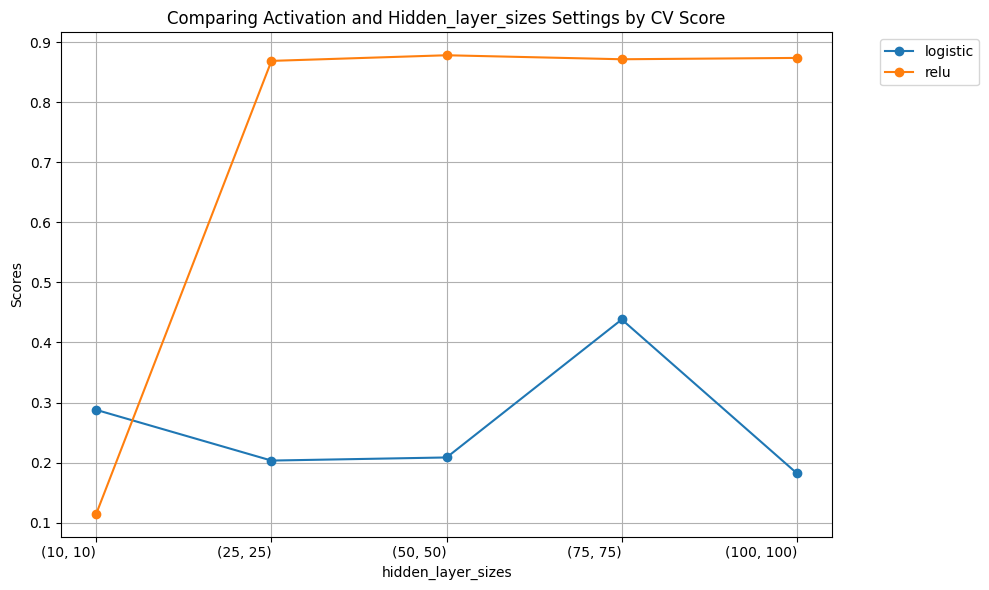

In [86]:
display_scores_line(two_layers_results)

In [36]:
# Join the results of the layers exploration, show the best performing combinations of layer and activation function
joined_layers_results = np.concatenate([finer_one_layer_results, two_layers_results])
# Sort results by score
sorted_results = sorted(joined_layers_results, key=lambda x: x['score'], reverse=True)
print("Top Layer Sizes by Score:")
for idx, param in enumerate(sorted_results[:10], 1):
    print(f"{idx}. Layers: {param['hidden_layer_sizes']}, Activation: {param['activation']}, Score: {param['score']}")

Top Layer Sizes by Score:
1. Layers: (45,), Activation: relu, Score: 0.890925925925926
2. Layers: (25,), Activation: relu, Score: 0.8898148148148147
3. Layers: (75,), Activation: relu, Score: 0.8856172839506172
4. Layers: (65,), Activation: relu, Score: 0.8850617283950617
5. Layers: (50, 50), Activation: relu, Score: 0.8782716049382715
6. Layers: (55,), Activation: relu, Score: 0.8770370370370371
7. Layers: (50,), Activation: relu, Score: 0.8750617283950618
8. Layers: (100, 100), Activation: relu, Score: 0.8738271604938271
9. Layers: (75, 75), Activation: relu, Score: 0.8716049382716049
10. Layers: (85,), Activation: relu, Score: 0.8700617283950617


Based on these results, a hidden layer of size 45 is to be used along with the relu activation function.

### <a id='toc1_2_2_'></a>[Exploring Solver](#toc0_)

In [38]:
params=  {
    'hidden_layer_sizes': [(45,),],
    'activation': ['relu'],
    'random_state': [30],
    'solver': ['lbfgs', 'sgd', 'adam'],}
params = list(ParameterGrid(params)) 
params

[{'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'solver': 'lbfgs'},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'solver': 'sgd'},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'solver': 'adam'}]

In [39]:
solver_results = mlp_model_cv_score(params)
solver_results

[{'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'solver': 'lbfgs',
  'score': 0.8777160493827161},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'solver': 'sgd',
  'score': 0.11499999999999999},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'random_state': 30,
  'solver': 'adam',
  'score': 0.890925925925926}]

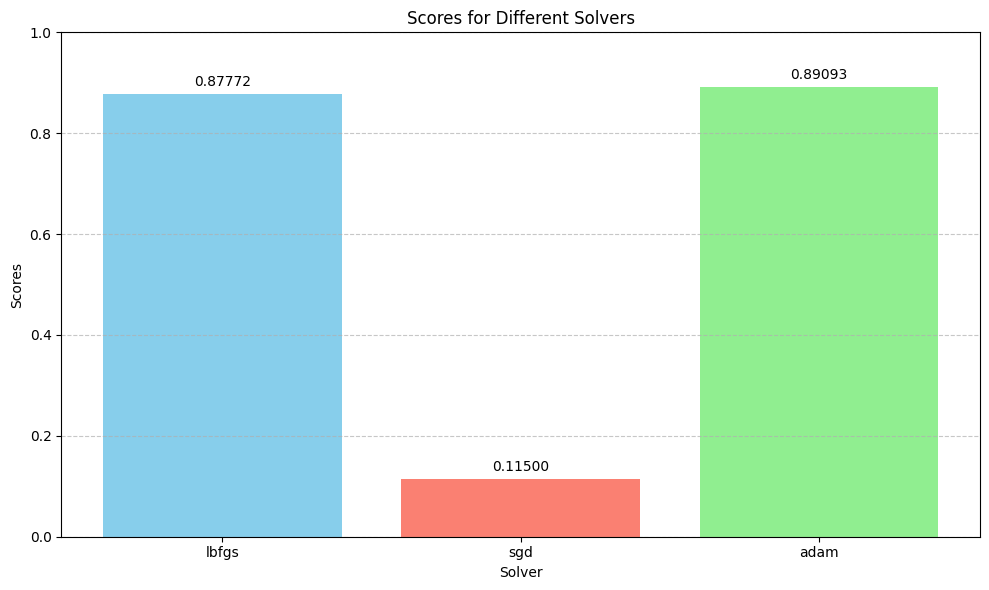

In [73]:
# Extracting data
solvers = [item['solver'] for item in solver_results]
scores = [item['score'] for item in solver_results]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(solvers, scores, color=['skyblue', 'salmon', 'lightgreen'])

# Add labels to bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{score:.5f}', ha='center', va='bottom')

plt.xlabel('Solver')
plt.ylabel('Scores')
plt.title('Scores for Different Solvers')
plt.ylim(0, 1)  # Set y-axis limit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The best solver is adam, and will be the one used going forward.

### <a id='toc1_2_3_'></a>[Exploring learning_rate_init](#toc0_)

In [67]:
params=  {
    'hidden_layer_sizes': [(45),], 
    'activation': ['relu'],
    'solver': ['adam'],
    'random_state': [30],
    'learning_rate_init': [0.001, 0.01, 0.1, 1]
    }
params = list(ParameterGrid(params)) 
params

[{'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam'},
 {'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 0.01,
  'random_state': 30,
  'solver': 'adam'},
 {'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 0.1,
  'random_state': 30,
  'solver': 'adam'},
 {'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 1,
  'random_state': 30,
  'solver': 'adam'}]

In [68]:
lr_results = mlp_model_cv_score(params)
lr_results

[{'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'score': 0.890925925925926},
 {'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 0.01,
  'random_state': 30,
  'solver': 'adam',
  'score': 0.11413580246913582},
 {'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 0.1,
  'random_state': 30,
  'solver': 'adam',
  'score': 0.11160493827160493},
 {'activation': 'relu',
  'hidden_layer_sizes': 45,
  'learning_rate_init': 1,
  'random_state': 30,
  'solver': 'adam',
  'score': 0.10981481481481481}]

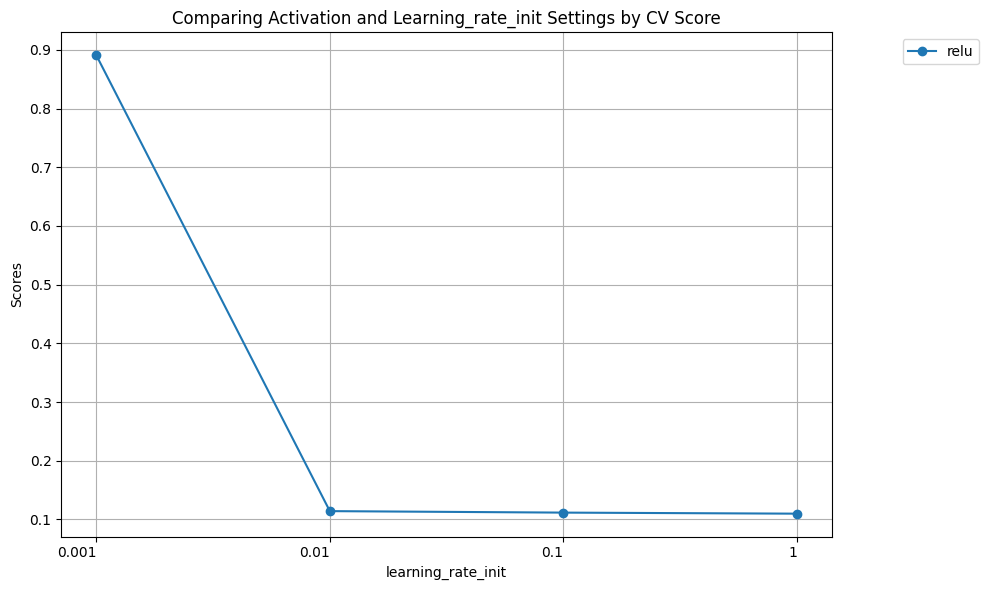

In [87]:
display_scores_line(lr_results, x_axis = 'learning_rate_init')

The best performing value is 0.001, so it will be the value used.

### <a id='toc1_2_4_'></a>[Exploring tol](#toc0_)

In [49]:
params = {
    'hidden_layer_sizes': [(45,),],
    'activation': ['relu'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-4, 1e-5, 1e-6],
}
params = list(ParameterGrid(params))
params

[{'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-06}]

In [50]:
tol_results = mlp_model_cv_score(params)
tol_results

[{'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.890925925925926},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-05,
  'score': 0.890925925925926},
 {'activation': 'relu',
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 1e-06,
  'score': 0.890925925925926}]

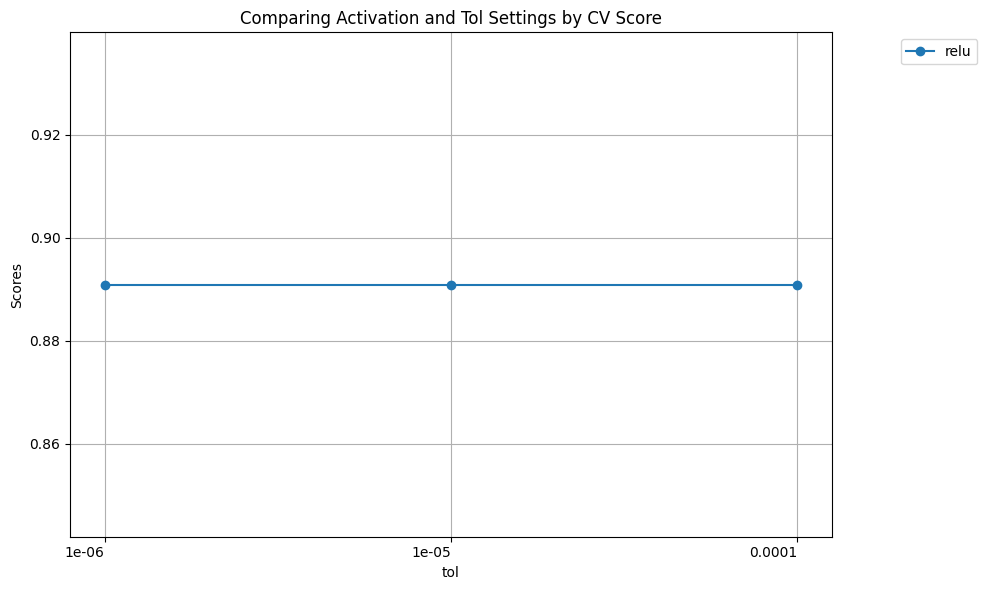

In [88]:
display_scores_line(tol_results, x_axis = 'tol')

Tol has no effect on performance of this model. The default value will be used (1e-4).

### <a id='toc1_2_5_'></a>[Adam-specific hyperparameters](#toc0_)

The next hyperparameters to be explored are specific to the 'adam' solver. These are:
* beta_1 (β₁) 
* beta_2 (β₁) 
* epsilon

In [52]:
params = {
    'hidden_layer_sizes': [(45,)],
    'activation': ['relu'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-4],
    'alpha': [0.0001, 0.001, 0.01],
}
params = list(ParameterGrid(params))
params

[{'activation': 'relu',
  'alpha': 0.0001,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.001,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001}]

In [53]:
alpha_results = mlp_model_cv_score(params)
alpha_results

[{'activation': 'relu',
  'alpha': 0.0001,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.890925925925926},
 {'activation': 'relu',
  'alpha': 0.001,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8909876543209876},
 {'activation': 'relu',
  'alpha': 0.01,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8935802469135801}]

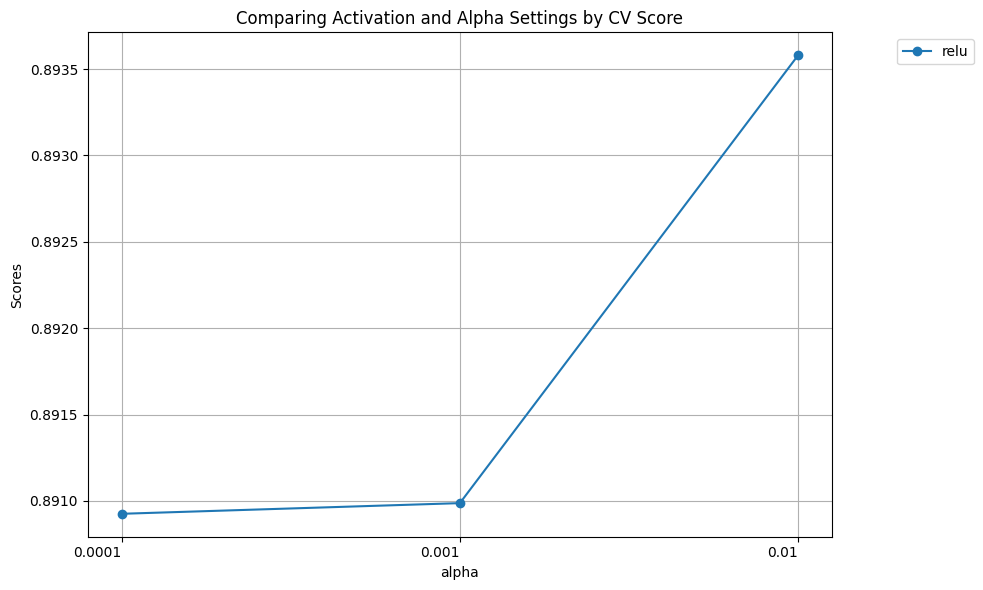

In [89]:
display_scores_line(alpha_results, x_axis = 'alpha')

An alpha value of 0.01 is the best performing value.

In [58]:
params = {
    'hidden_layer_sizes': [(45,)],
    'activation': ['relu'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-4],
    'alpha': [0.01],
    'beta_1': [0.9, 0.95, 0.99],
}
params = list(ParameterGrid(params))
params

[{'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.95,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.99,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001}]

In [59]:
beta1_results = mlp_model_cv_score(params)
beta1_results

[{'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8935802469135801},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.95,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8874074074074075},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.99,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.7750617283950618}]

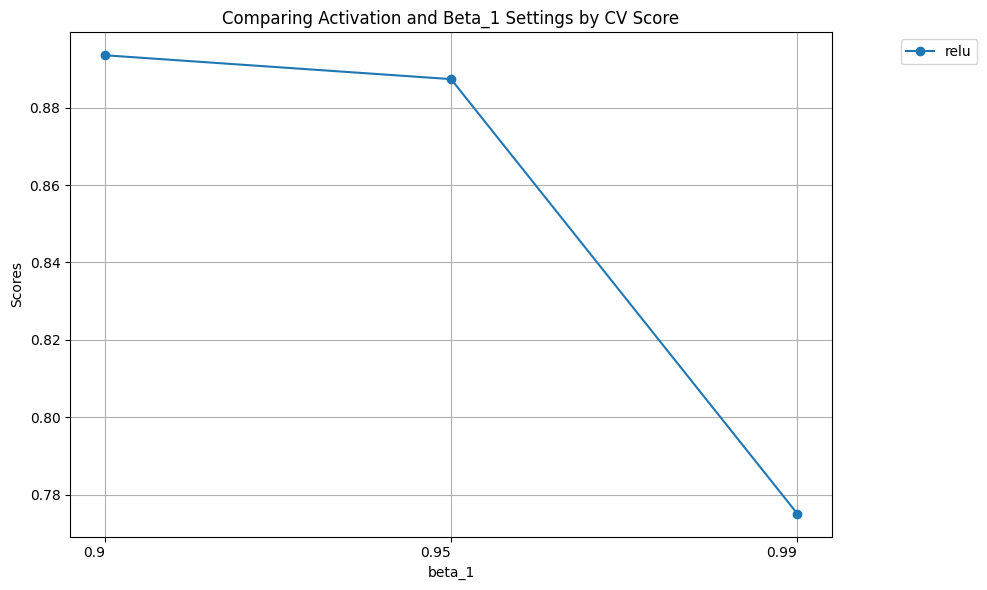

In [90]:
display_scores_line(beta1_results, x_axis = 'beta_1')

A beta_1 value of 0.9 is the best performing value. 

In [61]:
params = {
    'hidden_layer_sizes': [(45,)],
    'activation': ['relu'],    
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-4],
    'alpha': [0.01],
    'beta_1': [0.9],
    'beta_2': [0.999, 0.99, 0.95],
}
params = list(ParameterGrid(params))
params

[{'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.999,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001}]

In [62]:
beta2_results = mlp_model_cv_score(params)
beta2_results

[{'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.999,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8935802469135801},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8938888888888888},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.95,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8774691358024691}]

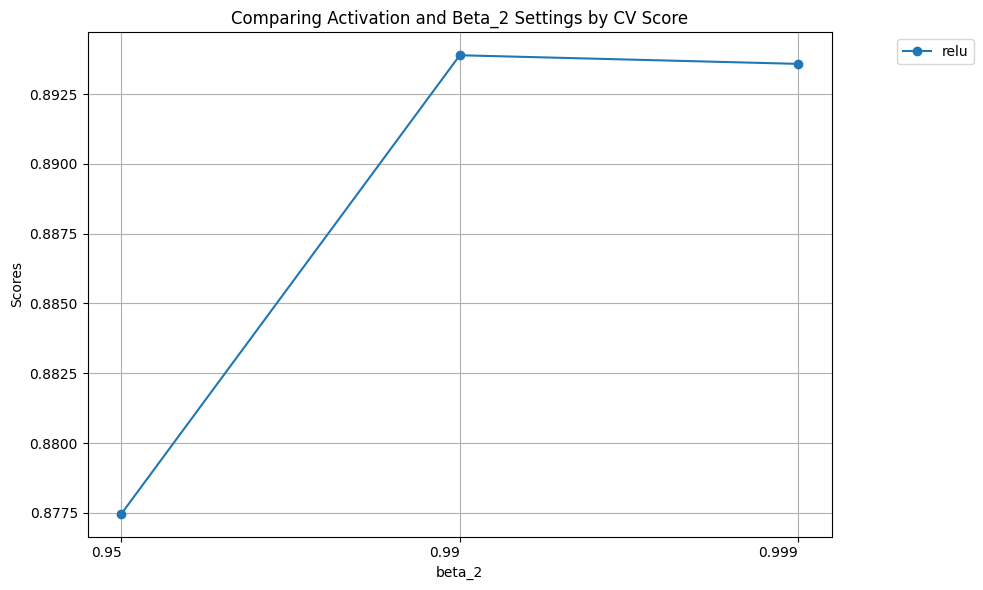

In [93]:
display_scores_line(beta2_results, x_axis = 'beta_2')

In [94]:
params = {
    'hidden_layer_sizes': [(45,)],
    'activation': ['relu'],
    'random_state': [30],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'tol': [1e-4],
    'alpha': [0.01],
    'beta_1': [0.9],
    'beta_2': [0.99],
    'epsilon': [1e-7, 1e-8, 1e-9]
}
params = list(ParameterGrid(params))
params

[{'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'epsilon': 1e-07,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'epsilon': 1e-08,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'epsilon': 1e-09,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001}]

In [95]:
eps_results = mlp_model_cv_score(params)
eps_results

[{'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'epsilon': 1e-07,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8843827160493827},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'epsilon': 1e-08,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8938888888888888},
 {'activation': 'relu',
  'alpha': 0.01,
  'beta_1': 0.9,
  'beta_2': 0.99,
  'epsilon': 1e-09,
  'hidden_layer_sizes': (45,),
  'learning_rate_init': 0.001,
  'random_state': 30,
  'solver': 'adam',
  'tol': 0.0001,
  'score': 0.8857407407407407}]

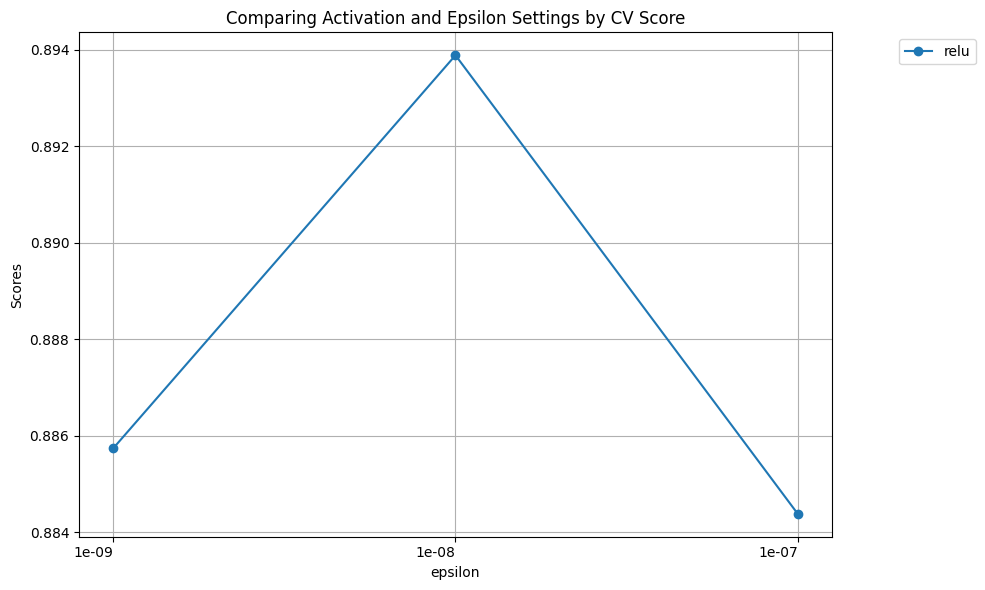

In [96]:
display_scores_line(eps_results, x_axis = 'epsilon')

Based on these results, 1e-08 will be the used value of epsilon (as it performs the best).

After applying appropriate pre-processing techniques, as well as hyperparameter exploration with comparisons of hyperparameter combinations using CV scores, an MLP classifier was created. This classifier very slightly outperforms the base model provided on sci-kit learn (CV score of 93.30% versus 93.35%). Results have been visualised and discussed. Suggestions for further hyperparameter exploration were provided. 

In [110]:
final_results = eps_results
best_params = max(final_results, key=lambda x: x['score'])
best_params

{'activation': 'relu',
 'alpha': 0.01,
 'beta_1': 0.9,
 'beta_2': 0.99,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (45,),
 'learning_rate_init': 0.001,
 'random_state': 30,
 'solver': 'adam',
 'tol': 0.0001,
 'score': 0.8938888888888888}

In [111]:
best_params_cv_score = best_params.pop('score')
best_params_cv_score

0.8938888888888888

In [112]:
#Train final model with best hyperparameters
best_model = MLPClassifier(**best_params)
best_params['score'] = best_params_cv_score
best_model.fit(features_train, targets_train)

MLPClassifier(alpha=0.01, beta_2=0.99, hidden_layer_sizes=(45,),
              random_state=30)

Saving the model

In [113]:
model_filename = 'task3_mlp.pkl'
# Save the model to a file using pickle
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

In [114]:
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
final_mlp = loaded_model

## <a id='toc1_3_'></a>[Evaluating the Chosen Model's Performance](#toc0_)

In [121]:
predict = final_mlp.predict(features_test)

In [122]:
print("Classification Report:")
print(classification_report(targets_test, predict))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.92      0.91       613
         1.0       0.93      0.95      0.94       605
         2.0       0.90      0.86      0.88       628
         3.0       0.71      0.84      0.77       499
         4.0       0.97      0.82      0.89       507
         5.0       0.92      0.82      0.87       409
         6.0       0.81      0.78      0.79       481
         7.0       0.86      0.98      0.91       583
         8.0       0.88      0.79      0.83       511
         9.0       0.93      0.99      0.96       564

    accuracy                           0.88      5400
   macro avg       0.88      0.87      0.88      5400
weighted avg       0.88      0.88      0.88      5400



Based on these results, it can be said:
* The precision, recall, and F1-score stay relatively stable across different classes, this suggests consistent performance across all classes. However, the model has some classes that perform better than others (2.0 vs 3.0, for example) 
* The accuracy of the model is 0.88. This is high.
* Overall, the model performs well for all classes, with an accuracy of 0.88 indicating there is room for improvement. Further hyperparameter exploration and fine-tuning could be performed to improve the model's performance, but it is not as necessary for this model due to the high performance. An MLP classifier appears to be very well suited to this dataset. Due to the slight increase in performance, the exploration of hyperparameters can be considered somewhat successful.

Next, some visualisations of performance will be displayed. These are a confusion matrix, a precision-recall curve and a ROC curve.

A confusion matrix is a table that is often used to describe the performance of a classification model. It assists in visualisation of the performance of a model. Elements on the diagonal represent correct predictions for each class, while off-diagonal elements represent misclassifications.

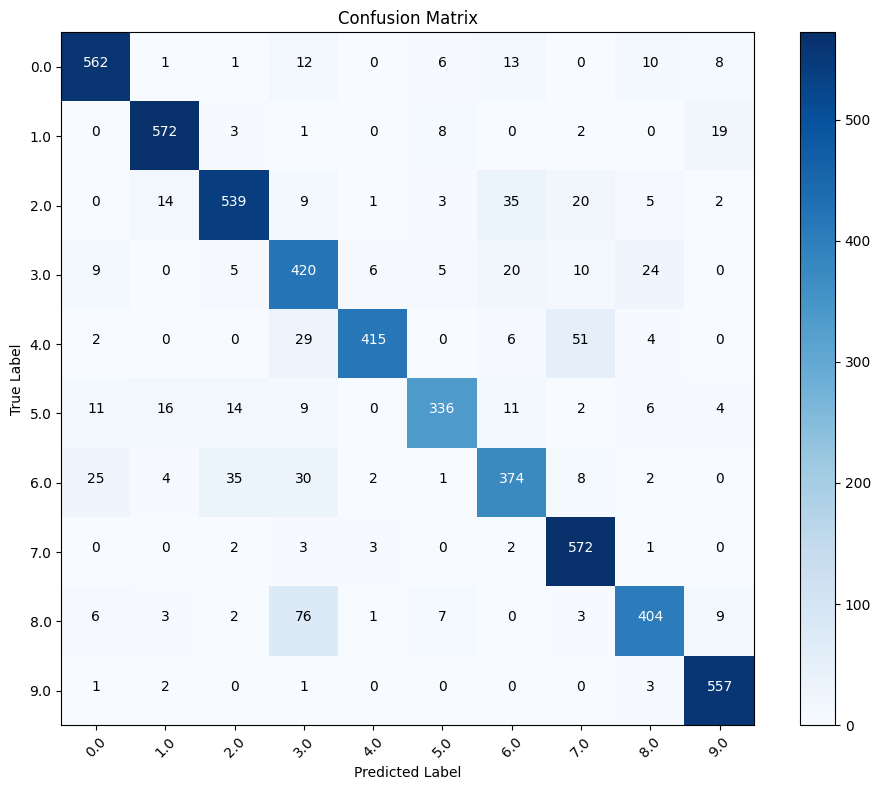

In [123]:
# Create the CM

# Get the unique class labels
classes = np.unique(targets_test)

# Confusion Matrix
cm = confusion_matrix(targets_test, predict)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

A precision-recall curve is a plot of the precision and recall for different classes in a classification model. This visualises the trade-off between precision and recall, indicating the model's performance. A higher area under the precision-recall curve (AUC-PR) indicates better overall performance of the model.

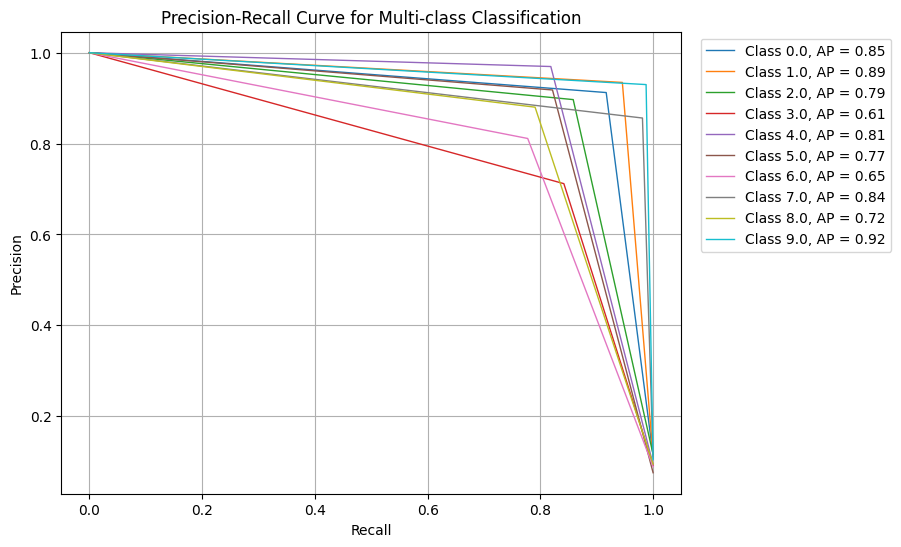

In [124]:
# Create p-r curve

classes = np.unique(targets_test)

# Initialise arrays to store precision and recall values for each class
precision = dict()
recall = dict()
average_precision = dict()  # Store average precision scores for each class

# Calculate precision and recall for each class
for cls in classes:
    # Binarise the targets for the current class
    targets_bin = np.where(targets_test == cls, 1, 0)
    targets_pred_bin = np.where(predict == cls, 1, 0)
    
    # Calculate precision, recall, and average precision
    precision[cls], recall[cls], _ = precision_recall_curve(targets_bin, targets_pred_bin)
    average_precision[cls] = average_precision_score(targets_bin, targets_pred_bin)

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for cls in classes:
    plt.plot(recall[cls], precision[cls], lw=1, label=f'Class {cls}, AP = {average_precision[cls]:.2f}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.grid(True)
plt.show()

The ROC curve is a plot that shows the true positive rate against the false positive rate for different classes. A higher AUC-ROC value indicates better overall performance of the model in distinguishing between the two classes.

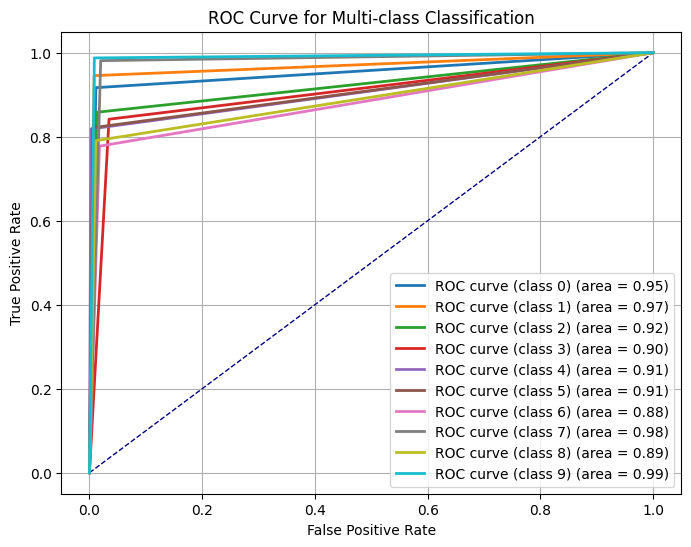

In [125]:
# Create the ROC curve

# Binarize the target variables
targets_bin = label_binarize(targets_test, classes=np.unique(targets_test))
targets_pred_bin = label_binarize(predict, classes=np.unique(targets_test))

# Determine the number of classes
n_classes = targets_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_bin[:, i], targets_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(targets_bin.ravel(), targets_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='navy', lw = 1, linestyle='--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw = 2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend()
plt.grid(True)
plt.show()

## <a id='toc1_4_'></a>[Hypothesis testing](#toc0_)

Hypothesis testing is a statistical method used to make decisions or inferences about whether a hypothesis is supported by data. To compare the performance of the two models (original and rescaled features), a paired t-test can be used. The paired t-test compares the means of two related groups (the CV scores for both models). This is a commonly used test for comparing two models.

### <a id='toc1_4_1_'></a>[Load the model from task 2 and get predictions](#toc0_)

In [161]:
model_filename = 'task2_mlp.pkl'
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
task2_mlp = loaded_model
# Use clone to get the model's parameters but without the model being fit to the data
task2_mlp = clone(task2_mlp)

In [162]:
task2_preprocess_pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ])  

In [163]:
task2_features_train, task2_targets_train, task2_features_test, task2_targets_test = load_dataset()
task2_features_train = task2_preprocess_pipeline.fit_transform(task2_features_train, task2_targets_train)
task2_features_test = task2_preprocess_pipeline.transform(task2_features_test)

In [164]:
task2_mlp_scores = cross_val_score(task2_mlp, task2_features_train, task2_targets_train, cv=10) 
task2_mlp_scores

array([0.93333333, 0.93641975, 0.92283951, 0.93518519, 0.93024691,
       0.94197531, 0.92283951, 0.93641975, 0.94012346, 0.93580247])

### <a id='toc1_4_2_'></a>[Get task 3 model accuracy](#toc0_)

In [167]:
model_filename = 'task3_mlp.pkl'
# Load the model from the file using pickle
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
task3_mlp = loaded_model
task3_mlp = clone(task3_mlp)


In [168]:
task3_mlp_scores = cross_val_score(task3_mlp, features_train, targets_train, cv=10) 
task3_mlp_scores

array([0.89753086, 0.90802469, 0.89320988, 0.91111111, 0.88271605,
       0.89320988, 0.88148148, 0.86604938, 0.89012346, 0.9154321 ])

### <a id='toc1_4_3_'></a>[Conduct Hypothesis testing](#toc0_)

The hypothesis:
* Null Hypothesis (H0):
The null hypothesis asserts that there is no difference in the mean accuracy of the MLP classifiers trained on the features from task2 and the rescaled features. ​

In [174]:
# Conduct the paired t-test
t_statistic, p_value = ttest_rel(task2_mlp_scores, task3_mlp_scores)
print(f'T-statistic: {t_statistic}, P-value: {p_value}')

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

T-statistic: 8.293100247651138, P-value: 1.658579220615015e-05
Reject the null hypothesis.


#### <a id='toc1_4_3_1_'></a>[Conclusion of test](#toc0_)

There is a statistically significant amount of evidence to suggest that the two models perform differently.

In [171]:
mean_accuracy_task2_mlp = np.mean(task2_mlp_scores)
mean_accuracy_task3_mlp = np.mean(task3_mlp_scores)
print(f'Mean Accuracy (Task 2 Features): {mean_accuracy_task2_mlp}')
print(f'Mean Accuracy (Rescaled Features): {mean_accuracy_task3_mlp}')

Mean Accuracy (Original Features): 0.9335185185185185
Mean Accuracy (Rescaled Features): 0.8938888888888888


The model developed in task 2 outperforms the model created in task 3.

## <a id='toc1_5_'></a>[Conclusion](#toc0_)

After applying appropriate pre-processing techniques (with rescaling to [10, 15]) as well as hyperparameter exploration with comparisons of hyperparameter combinations using CV scores, an MLP classifier was created. This classifier slightly outperforms the base model provided on sci-kit learn (CV score of 0.875 versus 0.894). Results have been visualised and discussed. Suggestions for further hyperparameter exploration were provided. 

In addition to this, hypothesis testing was conducted. The CV scores of the model from task 2 as well as the model created in this task were used for a paired T-test. The null hypothesis was rejected.

# <a id='toc2_'></a>[Markdown Question](#toc0_)

_What was the hypothesis you rejected in this task? How does p-value affect your decision? (150 words)_

## <a id='toc2_1_'></a>[Answer](#toc0_)

In this task, the hypothesis that we rejected is the null hypothesis, which states there is no significant difference in the performance of the two MLP classifiers.

The p-value affects the decision as, ff the p-value is less than the chosen significance level (set here at 0.05), then we reject the null hypothesis. This suggests that the observed difference in performance between the two models (before and after feature rescaling) is statistically significant.

However, if the p-value is greater than the chosen significance level, then do not reject the null hypothesis, as there is no statistically significant difference in performance between the two models.

For this task, if the p-value is less than 0.05, we conclude that there is a statistically significant difference in the performance of the MLP classifiers. If the p-value is greater than 0.05, we conclude that there is no statistically significant difference.